## AA TEST

Постановка задачи:

У нас есть данные АА-теста с '2022-05-17' по '2022-05-23'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

Импортируем необходимые библиотеки.

In [1]:
#импорт библиотек
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

Настроим подключение к ClickHouse.

In [2]:
#параметры соединения с clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

#SQL запрос 
q = """SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions 
WHERE toDate(time) between '2022-05-17' and '2022-05-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id"""

Загрузим данные. Посмотрим первые 5 строк.

In [3]:
#получение данных из clickhouse
df = pandahouse.read_clickhouse(q, connection=connection)

#вывод первых пяти строк данных
print(df.head())

   exp_group  user_id  likes  views       ctr
0          3   115383     11     36  0.305556
1          3   123580     15     92  0.163043
2          2   131473     26    148  0.175676
3          2    23985     12     66  0.181818
4          2    24523     17    120  0.141667


Нарисуем гистограмму по CTR

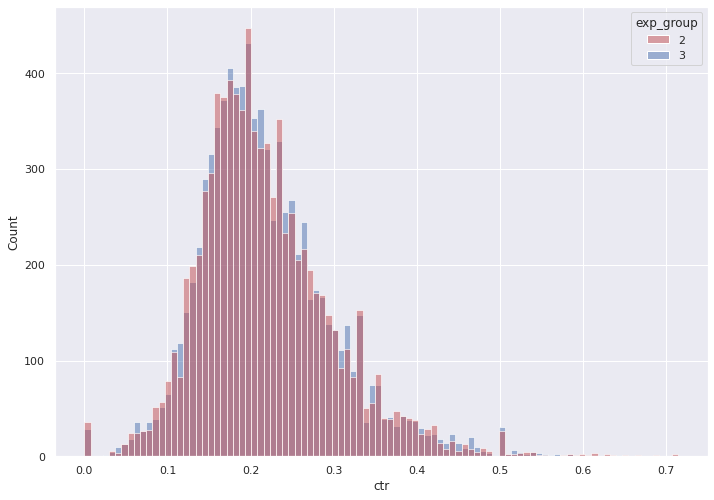

In [4]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 0 и 3
groups = sns.histplot(data = df[(df.exp_group == 2) | (df.exp_group == 3)], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Группы внешне очень похожи друг на друга.

Проведем 10000 АА тестов на выборках с возвращением размера 500, на группах 2 и 3.

In [5]:
number_of_tests = 10000 #количество тестов
sample_size = 500 #размер выборки
p_value = [] #список значений p_value

#Цикл для проведения Т-test. Результаты сохраняем в список p_value
for _ in range(number_of_tests):
#    a = [np.random.choice(df[df.exp_group == 2].ctr) for _ in range(sample_size)]
#    b = [np.random.choice(df[df.exp_group == 3].ctr) for _ in range(sample_size)]
#    p_value.append(stats.ttest_ind(a, b, equal_var=False))
    
    p_value.append(stats.ttest_ind(df[df.exp_group == 3].ctr.sample(n = sample_size, replace = True),
                                   df[df.exp_group == 2].ctr.sample(n = sample_size, replace = True),
                                   equal_var=False))


Результат тестов p_value преобразуем в DataFrame. Выведем первые 5 строк.

In [6]:
df_p_value = pd.DataFrame(p_value) #преобразование списка p_value в DataFrame
df_p_value.head() #вывод 5 первых строк датафрейма

,statistic,pvalue
0,-0.369226,0.712038
1,-0.962769,0.335898
2,0.985201,0.324765
3,1.762227,0.078338
4,-0.240904,0.809679


Построим гистограмму распределения p-value

<AxesSubplot:xlabel='pvalue', ylabel='Count'>

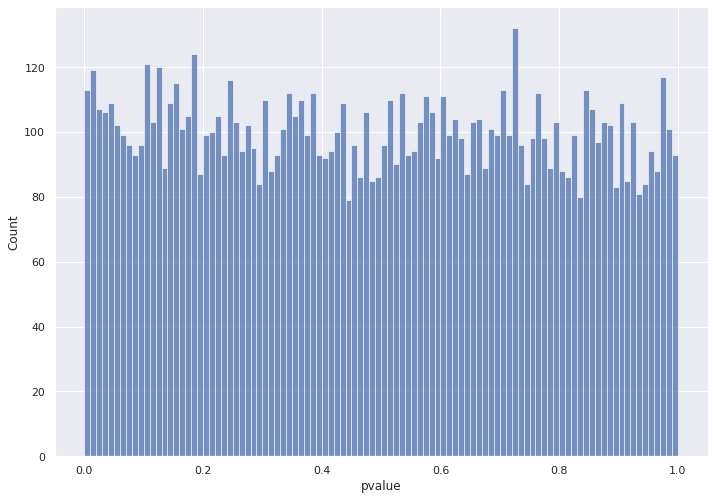

In [7]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})
#отрисовка гистограммы распределения p-value
sns.histplot(data = df_p_value.pvalue, bins = 100)

Посчитаем, какой процент значений p-value оказался меньше или равен 0.05

In [8]:
print(f"Процент значений p-value меньших либо равных 0.05 равен {df_p_value[df_p_value['pvalue']<=0.05]['pvalue'].count()/len(df_p_value.pvalue)*100}%")

Процент значений p-value меньших либо равных 0.05 равен 5.54%


## Вывод

На гистограмме видно, что значения p-value достаточно равномерно распределены на отрезке от 0 до 1. Процент значений p-value меньших или равных пяти при Т-тесте на подвыборках с повторением примерно равен 5%. При множественном повторении он коблется от 4.6 до 5.7 что можно признать погрешностью вычислений и особенностью хранения в Python чисел с плавающей точкой.

В проведенном АА тесте мы отклонили нулевую гипетезу примерно в 5 процентах случаев. Наша система сплитования работает корректно.